# Fully Bayesian Neural Networks - Simple Classification Problem

*Prepared by Maxim Ziatdinov (January 2025)*

This notebook demonstrates the application of fully Bayesian neural networks - where all weights are probabilistic - for a toy classfication problem.

Imports:

In [1]:
import sys
sys.path.append("..")

import neurobayes as nb

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

Define utility functions for data generation and visualization of results:

In [2]:
def create_feature_grid(X, margin=0.5, n_points=100):
    """
    Create a mesh grid for 2D feature space visualization.
    """
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, n_points),
                        np.linspace(y_min, y_max, n_points))
    grid = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, grid

def plot_bnn_predictions(X, y, bnn, figsize=(15, 7), margin=0.5, n_levels=15, alpha=0.7):
    """
    Visualize BNN predictions and uncertainty on a 2D feature space.
    """
    # Create mesh grid for visualization
    xx, yy, grid = create_feature_grid(X, margin)
    
    # Get predictions and uncertainty for the mesh grid
    mesh_probs, mesh_uncertainty = bnn.predict(grid)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Decision Boundary and Predictions
    probs_class1 = mesh_probs[:, 1].reshape(xx.shape)
    contour1 = ax1.contourf(xx, yy, probs_class1,
                           alpha=alpha, levels=n_levels, cmap=plt.cm.RdYlBu)
    # Add decision boundary line
    boundary = ax1.contour(xx, yy, probs_class1, levels=[0.5],
                          colors='k', linestyles='--', linewidths=2)
    scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y,
                          cmap=plt.cm.RdYlBu, edgecolors='black')
    
    # Create legend elements
    legend_elements1 = [
        Patch(facecolor='blue', alpha=0.7, label='High Prob. Class 0'),
        Patch(facecolor='red', alpha=0.7, label='High Prob. Class 1'),
        plt.Line2D([0], [0], color='k', linestyle='--', label='Decision Boundary'),
        plt.scatter([0], [0], c='blue', edgecolors='black', label='True Class 0'),
        plt.scatter([0], [0], c='red', edgecolors='black', label='True Class 1')
    ]
    ax1.legend(handles=legend_elements1, loc='best', framealpha=0.9)
    ax1.set_title('Decision Boundary and True Classes')
    
    # Plot 2: Uncertainty Landscape
    uncertainty_plot = ax2.contourf(xx, yy, mesh_uncertainty.reshape(xx.shape),
                                  cmap='inferno', levels=n_levels, alpha=alpha)
    scatter2 = ax2.scatter(X[:, 0], X[:, 1], c=y,
                          cmap=plt.cm.RdYlBu, edgecolors='black')
    # Add decision boundary line
    ax2.contour(xx, yy, probs_class1, levels=[0.5],
                colors='k', linestyles='--', linewidths=2)
    
    # Create legend elements
    legend_elements2 = [
        Patch(facecolor='purple', alpha=0.7, label='Low Uncertainty'),
        Patch(facecolor='yellow', alpha=0.7, label='High Uncertainty'),
        plt.Line2D([0], [0], color='k', linestyle='--', label='Decision Boundary'),
        plt.scatter([0], [0], c='blue', edgecolors='black', label='True Class 0'),
        plt.scatter([0], [0], c='red', edgecolors='black', label='True Class 1')
    ]
    ax2.legend(handles=legend_elements2, loc='best', framealpha=0.9)
    ax2.set_title('Prediction Uncertainty')
    
    # Adding labels
    for ax in [ax1, ax2]:
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    return fig, (ax1, ax2)

def plot_bnn_realizations(X, y, bnn, figsize=(7, 7), margin=0.5, alpha=0.05, seed=0):
    """
    Visualize multiple realizations of BNN decision boundaries using existing samples.
    """
    
    import jax.random as random

    # Create mesh grid for visualization
    xx, yy, grid = create_feature_grid(X, margin)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get samples from posterior
    rng_key = random.PRNGKey(seed)
    samples = bnn.get_samples()
    predictions = bnn.sample_from_posterior(rng_key, grid, samples, return_sites=["probs"])
    predictive_probs = predictions["probs"]  # shape: (n_samples, n_points, 2)
    
    n_samples = predictive_probs.shape[0]
    
    # Plot multiple realizations of the decision boundary
    for i in range(n_samples):
        # Get predictions for this sample
        sample_probs = predictive_probs[i]  # shape: (n_points, 2)
        probs_class1 = sample_probs[:, 1].reshape(xx.shape)
        
        # Plot decision boundary for this sample
        ax.contour(xx, yy, probs_class1, levels=[0.5],
                  colors='green', linestyles='-', linewidths=1, alpha=alpha)
    
    # Compute and plot mean prediction boundary
    mean_probs = predictive_probs.mean(axis=0)  # average over samples
    mean_probs_class1 = mean_probs[:, 1].reshape(xx.shape)
    ax.contour(xx, yy, mean_probs_class1, levels=[0.5],
               colors='black', linestyles='--', linewidths=2)
    
    # Plot data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y,
                        cmap=plt.cm.RdYlBu, edgecolors='black', zorder=2)
    
    # Create legend elements
    legend_elements = [
        plt.Line2D([0], [0], color='green', label='Decision Boundary Samples'),
        plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Mean Decision Boundary'),
        plt.scatter([0], [0], c='blue', edgecolors='black', label='True Class 0'),
        plt.scatter([0], [0], c='red', edgecolors='black', label='True Class 1')
    ]
    ax.legend(handles=legend_elements, loc='best', framealpha=0.9)
    
    # Add labels
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('BNN Decision Boundary Realizations')
    
    plt.tight_layout()
    return fig, ax


def plot_nn_predictions(X, y, nn, figsize=(7, 7), margin=0.5, n_levels=15, alpha=0.7):
    """
    Visualize deterministic neural network predictions on a 2D feature space.
    """
    # Create mesh grid for visualization
    xx, yy, grid = create_feature_grid(X, margin)
    
    # Get predictions for the mesh grid
    mesh_probs = nn.predict(grid)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot decision boundary and predictions
    probs_class1 = mesh_probs[:, 1].reshape(xx.shape)
    contour = ax.contourf(xx, yy, probs_class1,
                         alpha=alpha, levels=n_levels, cmap=plt.cm.RdYlBu)
    # Add decision boundary line
    boundary = ax.contour(xx, yy, probs_class1, levels=[0.5],
                         colors='k', linestyles='--', linewidths=2)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y,
                        cmap=plt.cm.RdYlBu, edgecolors='black')
    
    # Create legend elements
    legend_elements = [
        Patch(facecolor='blue', alpha=0.7, label='High Prob. Class 0'),
        Patch(facecolor='red', alpha=0.7, label='High Prob. Class 1'),
        plt.Line2D([0], [0], color='k', linestyle='--', label='Decision Boundary'),
        plt.scatter([0], [0], c='blue', edgecolors='black', label='True Class 0'),
        plt.scatter([0], [0], c='red', edgecolors='black', label='True Class 1')
    ]
    ax.legend(handles=legend_elements, loc='best', framealpha=0.9)
    ax.set_title('Decision Boundary and True Classes')
    
    # Adding labels
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    plt.tight_layout()
    
    return fig, ax

## Low Noise level

Generate data:

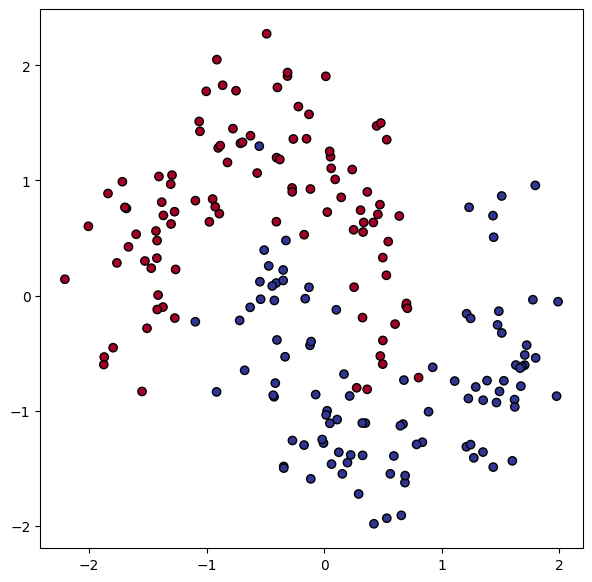

In [3]:
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)  # noise = 0.2, 0.5
X = StandardScaler().fit_transform(X)

plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black')

### Deterministic NN

Initialize and train a simple deterministic neural network:

Training Progress: 100%|██████████| 200/200 [00:02<00:00, 98.51it/s, Epoch 200/200, LR: 0.000100, Loss: 0.3480 ] 


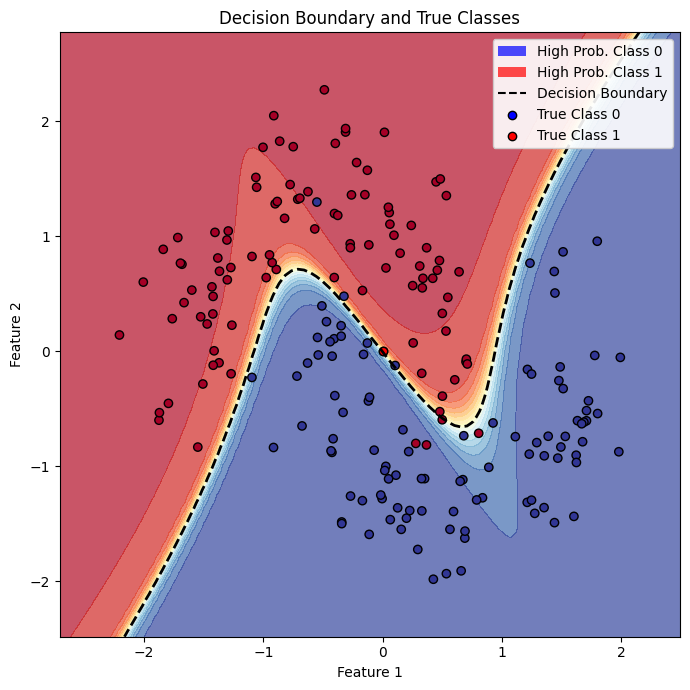

In [4]:
architecture = nb.FlaxMLP(hidden_dims=[8, 8, 8, 8], target_dim=2, classification=True)
detnn = nb.DeterministicNN(
    architecture, input_shape=X.shape,
    loss='classification', learning_rate=5e-3, map=False,
    swa_config={'schedule': 'linear', 'start_pct': 0.75, 'swa_lr': 1e-4}
)

detnn.train(X, y, epochs=200)

plot_nn_predictions(X, y, detnn)
plt.show()

### Full BNN

Now use the same architecture but make all weights probabilistic:

sample: 100%|██████████| 2000/2000 [00:27<00:00, 72.70it/s, 511 steps of size 1.03e-02. acc. prob=0.92] 


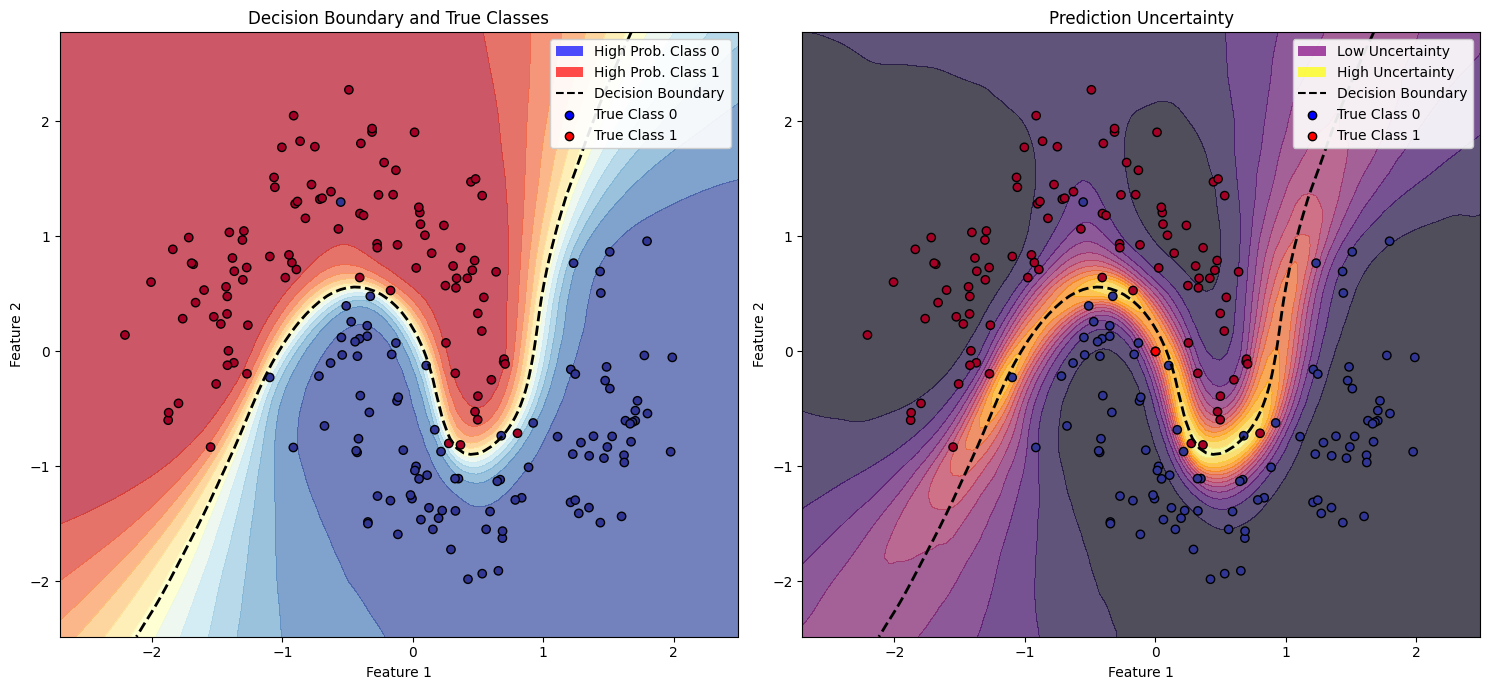

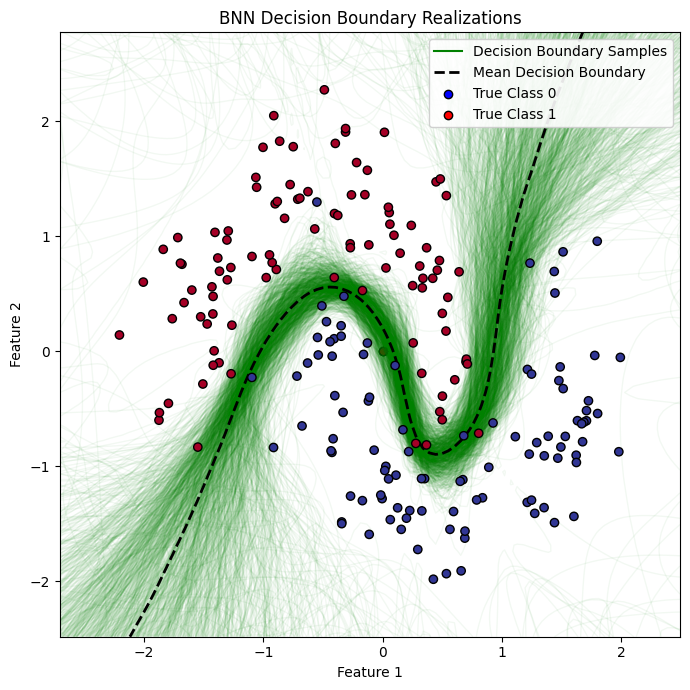

In [5]:
architecture = nb.FlaxMLP(
    hidden_dims=[8, 8, 8, 8],
    target_dim=2  # no classification flag here, since softmax will be applied at the BNN level
)

# Initialize BNN
bnn = nb.BNN(
    architecture,
    num_classes=2
)

# Fit the model
bnn.fit(
    X=X,
    y=y,
    num_warmup=1000,
    num_samples=1000,
)

fig, (ax1, ax2) = plot_bnn_predictions(X, y, bnn)
plt.show()

fig, ax = plot_bnn_realizations(X, y, bnn)
plt.show()

## High Noise Level

Same as before, but for data with a higher noise level.

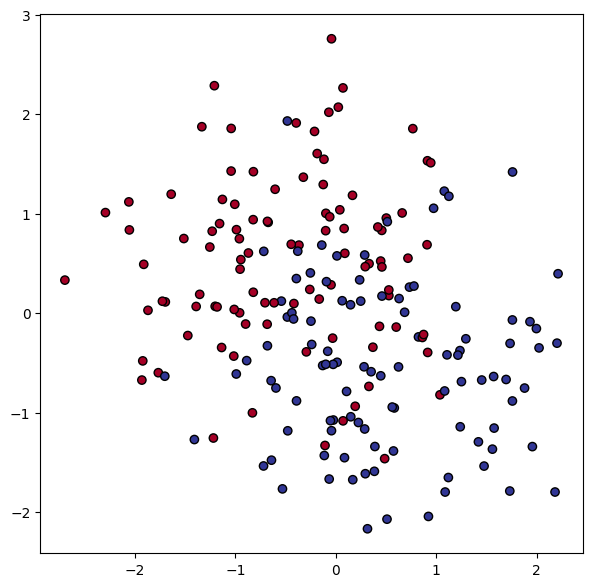

In [6]:
X, y = make_moons(n_samples=200, noise=0.5, random_state=42)
X = StandardScaler().fit_transform(X)

plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black')

### Standard NN

Training Progress: 100%|██████████| 200/200 [00:02<00:00, 97.44it/s, Epoch 200/200, LR: 0.000100, Loss: 0.4776 ] 


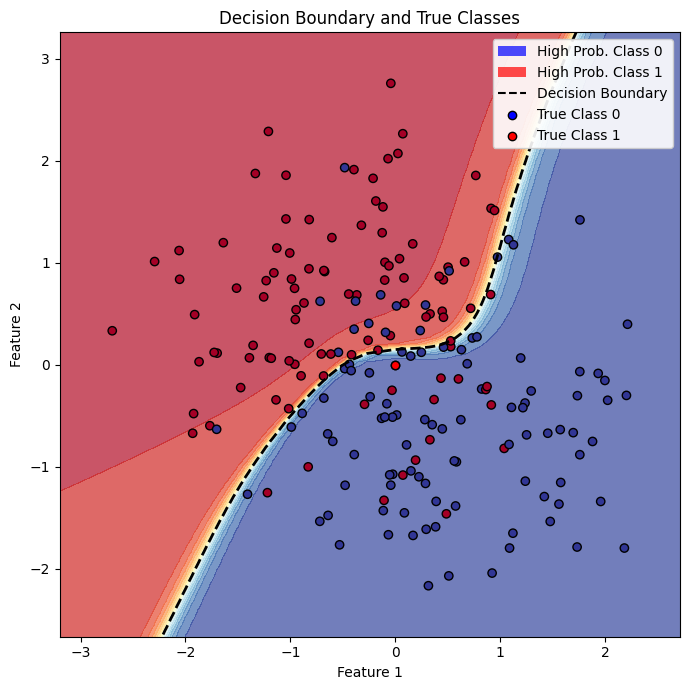

In [7]:
architecture = nb.FlaxMLP(hidden_dims=[8, 8, 8, 8], target_dim=2, classification=True)
detnn = nb.DeterministicNN(
    architecture, input_shape=X.shape,
    loss='classification', learning_rate=5e-3, map=False,
    swa_config={'schedule': 'linear', 'start_pct': 0.75, 'swa_lr': 1e-4}
)

detnn.train(X, y, epochs=200)

plot_nn_predictions(X, y, detnn)
plt.show()

### Full BNN

sample: 100%|██████████| 2000/2000 [00:17<00:00, 112.44it/s, 255 steps of size 1.54e-02. acc. prob=0.93]


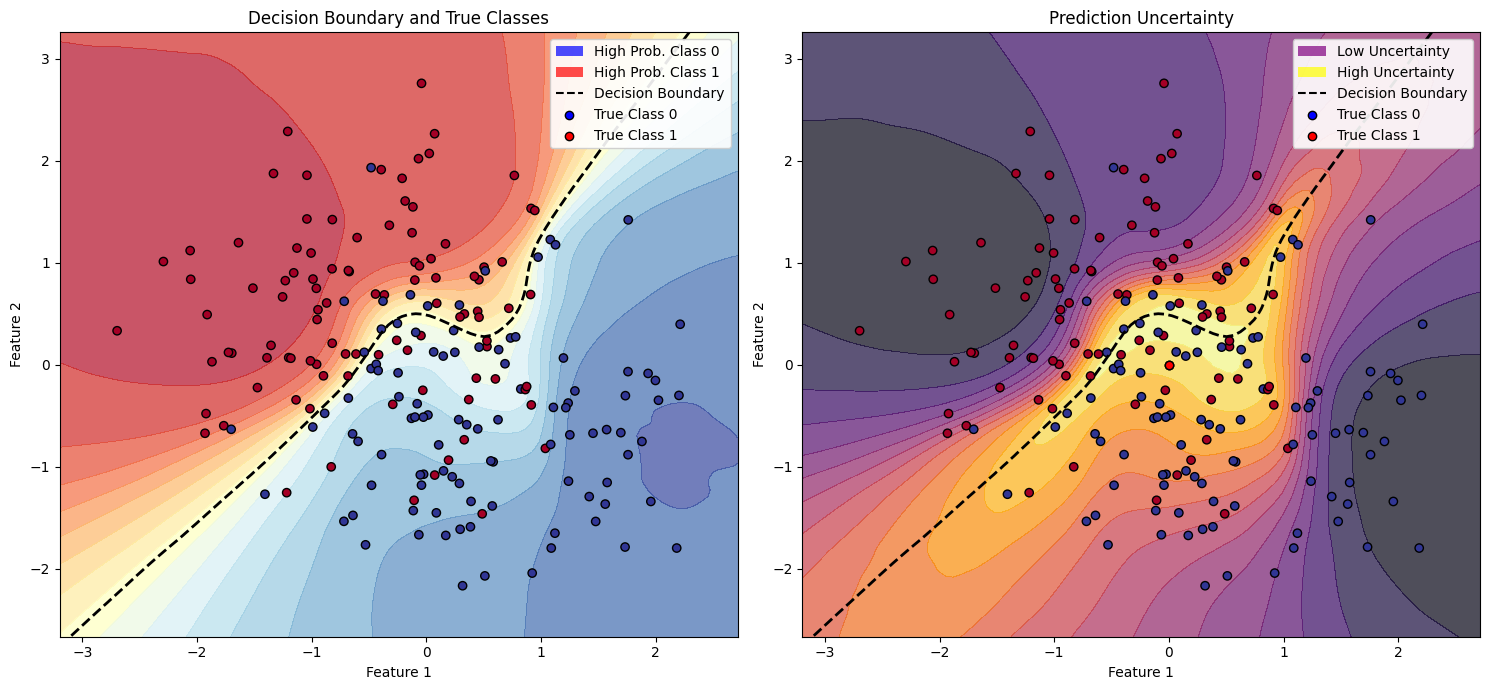

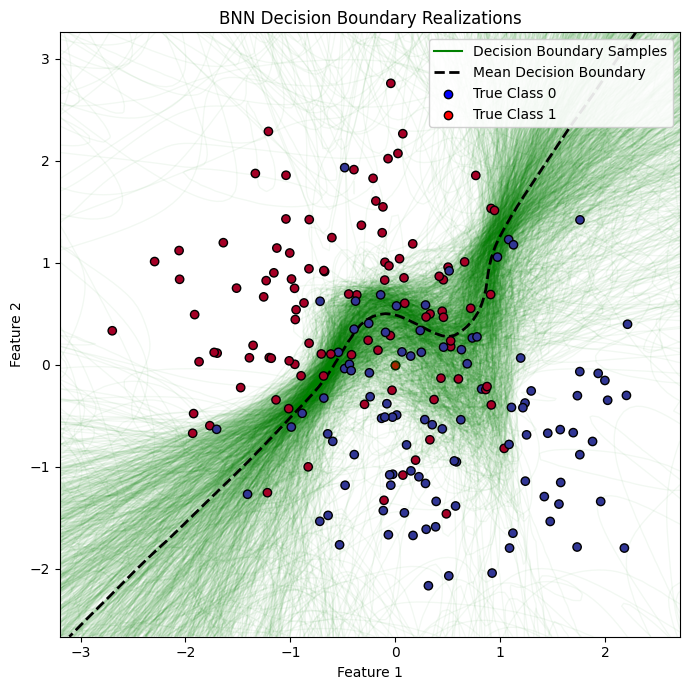

In [8]:
architecture = nb.FlaxMLP(hidden_dims=[8, 8, 8, 8], target_dim=2)

# Initialize BNN
bnn = nb.BNN(
    architecture,
    num_classes=2
)

# Fit the model
bnn.fit(
    X=X,
    y=y,
    num_warmup=1000,
    num_samples=1000,
)

fig, (ax1, ax2) = plot_bnn_predictions(X, y, bnn)
plt.show()

fig, ax = plot_bnn_realizations(X, y, bnn)
plt.show()

Unlike deterministic NN, which learns a single fixed set of parameters that define one decision boundary between classes, a full BNN learns a distribution over model parameters, enabling it to capture multiple possible solutions simultaneously. The BNN prediction is a collection of plausible boundaries, each representing a different valid way to separate the classes, weighted by the model's posterior distribution. This approach naturally captures model uncertainty and provides more robust predictions, particularly in regions with sparse data or ambiguous class separation.